## Model 구현하기
1. Resnet 모델 형태로 직접 구현
2. Pretrained Model(ImageNet Pretrained Weight) 사용
    - Fine-tuning
    - Feature Extraction

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import cv2
import albumentations as A

from albumentations.pytorch import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [215]:
# 나이만 맞추는 용도의 데이터프레임 생성 (기존 train_label.csv에서 label만 수정)

# def age_change(x):
#     if x in [0, 3, 6, 9, 12, 15]:
#         return 0
#     elif x in [1, 4, 7, 10, 13, 16]:
#         return 1
#     else:
#         return 2

# df['label'] =  df['label'].apply(age_change)
# df.head()


,Unnamed: 0,path,label
0,0,../input/data/train/images/000001_female_Asian...,1
1,1,../input/data/train/images/000001_female_Asian...,1
2,2,../input/data/train/images/000001_female_Asian...,1
3,3,../input/data/train/images/000001_female_Asian...,1
4,4,../input/data/train/images/000001_female_Asian...,1


In [2]:
train_df = pd.read_csv('train_label.csv')
aug_df = pd.read_csv('augment.csv')
aug_df3 = pd.read_csv('augment3.csv') # 2/27 추가

concat_df = pd.concat([train_df,aug_df], ignore_index=True)
df = pd.concat([concat_df,aug_df3], ignore_index=True) # 최종 df



# Transform Compose
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(350),
    # torchvision.transforms.Resize((350,350),Image.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.2,0.2,0.2)),
])


# # albumentation 
# data_transform = A.Compose([
#     A.Resize(350, 350),
#     A.HorizontalFlip(p=0.7),
#     A.HueSaturationValue(p=0.7),
#     A.RandomBrightnessContrast(p=0.5),
#     A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#     A.OneOf([
#         A.MotionBlur(p=0.7),
#         A.OpticalDistortion(p=0.7),
#         A.GaussNoise(p=0.7),
#     ], p=1),
#     A.Normalize(mean=0.5, std=0.5, max_pixel_value=1.0),
#     transforms.ToTensorV2()
# ])

# Custom Dataset 생성
class CustomDataset(Dataset):
    # 초기 데이터 생성 방법을 지정
    def __init__(self, df, transforms=None):
        self.df = df
        self.image_data = self.df['path']   # x data, 이미지
        self.image_label = self.df['label'] # y data, 레이블

        self.transform = transforms

    # 데이터 전체 길이
    def __len__(self):
        return len(self.image_label)

    # 인덱스 주었을 때 반환되는 데이터의 형태
    def __getitem__(self, idx):
        image = Image.open(self.image_data.iloc[idx])
        label = self.image_label.iloc[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)


    # # albumentation 사용했을 경우
    # def __getitem__(self, idx):
    #     label = self.image_label.iloc[idx]
    #     # Read an image with OpenCV
    #     image = cv2.imread(self.image_data.iloc[idx])
        
    #     # By default OpenCV uses BGR color space for color images,
    #     # so we need to convert the image to RGB color space.
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #     if self.transform:
    #         augmented = self.transform(image=image) 
    #         image = augmented['image']

        # return image, torch.tensor(label)

valid set 만들기

In [3]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df, test_size = 0.25, shuffle=True, stratify=df['label'], random_state=1234)
print(train.shape, valid.shape)

(30966, 3) (10323, 3)


In [245]:
# train
labels_unique, counts = np.unique(train['label'], return_counts=True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in train['label']]
train_sampler = WeightedRandomSampler(example_weights, len(train['label']))

# valid
labels_unique, counts = np.unique(valid['label'], return_counts=True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in valid['label']]
valid_sampler = WeightedRandomSampler(example_weights, len(valid['label']))


Dataset, Dataloader

In [4]:
train_dataset = CustomDataset(train, data_transform)
print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)

30966


In [5]:
valid_dataset = CustomDataset(valid, data_transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=64, sampler=valid_sampler)

In [6]:
next(iter(valid_dataloader))[0].shape

torch.Size([128, 3, 350, 350])

In [89]:
# import numpy as np
# import random

# img, label = train_dataset[random.randint(0, len(train_dataset))]
# print(img.shape, label)

# img = np.array(img)
# img = np.transpose(img, (1,2,0))
# print(img.shape)
# plt.imshow(img)
# plt.title(f'label: {label}')
# plt.axis('off')
# plt.show()

### Pretrained ResNet
1. fc layer 수정 : out_feature를 18로 수정
2. pretrained model version 3가지
    - fine-tuning : 전체 네트워크 학습
    - feature extractor : 앞의 파라미터들에 대해 역전파를 수행하지 않음 (클래스 많을 땐, 별로?)
    - 모델 3개 만들어서(마스크, 나이, 성별) 예측하고 합침

In [7]:
resnet18 = torchvision.models.resnet18(pretrained=True)
# resnet18

#### fine-tuning

In [9]:
resnet18.fc = nn.Linear(in_features=512, out_features=18, bias=True)
model = resnet18.to(device)

# xavier uniform
import math
torch.nn.init.xavier_uniform_(resnet18.fc.weight)
stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
resnet18.fc.bias.data.uniform_(-stdv, stdv)

tensor([-0.0312, -0.0396, -0.0015, -0.0217, -0.0355,  0.0402, -0.0033, -0.0342,
        -0.0333,  0.0126, -0.0342, -0.0345, -0.0207,  0.0380,  0.0111,  0.0390,
         0.0414, -0.0320], device='cuda:0')

In [16]:
import torchvision
model = torchvision.models.mobilenet_v2(pretrained=True)
# print(mobile_model)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 18)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [6]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=18)


# for param in model.parameters():
#     param.requires_grad = True

# num_ftrs = model._fc.in_features
# model._fc = nn.Linear(num_ftrs, 18)
model.to(device)

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [6]:
import timm
# timm.list_models("vit*")
model = timm.create_model("vit_base_patch16_384", pretrained=True)
model.head = nn.Linear(model.head.in_features, 18, bias=True)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

#### Feature Extrator

#### Pytorch 심화과제 [Transfer Learning] 코드 참고

#### Focal Loss 함수

In [251]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True, device='cpu'):
        super(FocalLoss, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average
        self.device = device

    def forward(self, input, target):
        # input : N * C (btach_size, num_class)
        # target : N (batch_size)

        CE = F.cross_entropy(input, target, reduction='none')  # -log(pt)
        pt = torch.exp(-CE)  # pt
        loss = (1 - pt) ** self.gamma * CE  # -(1-pt)^rlog(pt)

        if self.alpha is not None:
            alpha = torch.tensor(self.alpha, dtype=torch.float).to(self.device)
            # in case that a minority class is not selected when mini-batch sampling
            if len(self.alpha) != len(torch.unique(target)):
                temp = torch.zeros(len(self.alpha)).to(self.device)
                temp[torch.unique(target)] = alpha.index_select(0, torch.unique(target))
                alpha_t = temp.gather(0, target)
                loss = alpha_t * loss
            else:
                alpha_t = alpha.gather(0, target)
                loss = alpha_t * loss

        if self.size_average:
            loss = torch.mean(loss)

        return loss

#### cutmix 함수

In [10]:
import random
# 랜덤 위치에서 패치 만들지 않고, 가로 세로로 절반만 자르는 함수
def half_bbox(size, lam):
    W = size[2]
    H = size[3]

    # 왼쪽, 오른쪽, 위쪽, 아랫쪽
    # (수정) 
    idx = random.randint(0,1)

    bbx1 = [0, 0]
    bby1 = [0, H//2]
    
    bbx2 = [W, W]
    bby2 = [H//2, H]

    return bbx1[idx], bby1[idx], bbx2[idx], bby2[idx]

In [11]:

LEARNING_RATE = 0.001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
# loss_fn = FocalLoss(gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

In [1]:
### 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
    elif phase == "test":
      model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

    for ind, (images, labels) in enumerate(dataloaders[phase]):
      # (참고.해보기) 현재 tqdm으로 출력되는 것이 단순히 진행 상황 뿐인데 현재 epoch, running_loss와 running_acc을 출력하려면 어떻게 할 수 있는지 tqdm 문서를 보고 해봅시다!
      # hint - with, pbar
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

      with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
        logits = model(images)
        _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
        loss = loss_fn(logits, labels)

        if phase == "train":
          loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
          optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

      running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
      running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
      best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

#### cutmix 추가

In [12]:
### 학습 코드 시작
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
  for phase in ["train", "test"]:
    running_loss = 0.
    running_acc = 0.
    if phase == "train":
      model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
    elif phase == "test":
      model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

    for ind, (images, labels) in enumerate(dataloaders[phase]):

      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

      with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
        
        #### cutmix 추가

        r = np.random.rand(1)
        if r <= 1:
          lam = 1/2
          rand_index = torch.randperm(images.size()[0]).cuda()
          target_a = labels
          target_b = labels[rand_index]
          bbx1, bby1, bbx2, bby2 = half_bbox(images.size(), lam)
          images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]


          logits = model(images)
          _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
          loss = loss_fn(logits, target_a) * lam + loss_fn(logits, target_b) * (1. - lam)

          if phase == "train":
            loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
            optimizer.step() # 계산된 gradient를 가지고 모델 업데이트
        
        
        else:
          logits = model(images)
          _, preds = torch.max(logits, 1)
          loss = loss_fn(logits, labels)

          if phase == "train":
            loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
            optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

        #### cutmix 끝

        
      running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
      running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

    # 한 epoch이 모두 종료되었을 때,
    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_acc / len(dataloaders[phase].dataset)

    print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
    if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
      best_test_accuracy = epoch_acc
    if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
      best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 1.297, 평균 Accuracy : 0.476
현재 epoch-0의 test-데이터 셋에서 평균 Loss : 1.178, 평균 Accuracy : 0.499
현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.986, 평균 Accuracy : 0.513
현재 epoch-1의 test-데이터 셋에서 평균 Loss : 1.040, 평균 Accuracy : 0.514
현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.891, 평균 Accuracy : 0.523
현재 epoch-2의 test-데이터 셋에서 평균 Loss : 1.056, 평균 Accuracy : 0.505
현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.836, 평균 Accuracy : 0.533
현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.868, 평균 Accuracy : 0.526
현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.799, 평균 Accuracy : 0.533
현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.878, 평균 Accuracy : 0.519
학습 종료!
최고 accuracy : 0.5262036323547363, 최고 낮은 loss : 0.868227056520202


In [13]:
# ## 저장
# import torch
# torch.save(model.state_dict(), 'LB_1.pth')

In [14]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        for i , (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)

            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [284]:
valid_testing_dataloder = DataLoader(valid_dataset, shuffle=False)
check_eval_df = check_eval(valid, valid_testing_dataloder, resnet18, device)
check_eval_df

,path,pred,target
0,../input/data/train/images/001252_male_Asian_2...,0,0
1,../input/data/train/images/003739_female_Asian...,4,4
2,../input/data/train/images/003710_female_Asian...,4,5
3,../input/data/train/images/000659_male_Asian_5...,1,1
4,../input/data/train/images/000048_female_Asian...,4,4
...,...,...,...
4720,../input/data/train/images/006699_male_Asian_1...,0,0
4721,../input/data/train/images/001016_male_Asian_2...,12,12
4722,../input/data/train/images/001566_female_Asian...,15,15
4723,../input/data/train/images/001903_female_Asian...,5,5


In [285]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
print(len(wrong_df))
wrong_df.head()


46


,path,pred,target
0,../input/data/train/images/003710_female_Asian...,4,5
1,../input/data/train/images/005543_female_Asian...,3,4
2,../input/data/train/images/005488_male_Asian_5...,10,7
3,../input/data/train/images/005504_female_Asian...,16,17
4,../input/data/train/images/006613_male_Asian_1...,0,6


In [287]:
from sklearn.metrics import f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average='macro')

0.9792377756492225

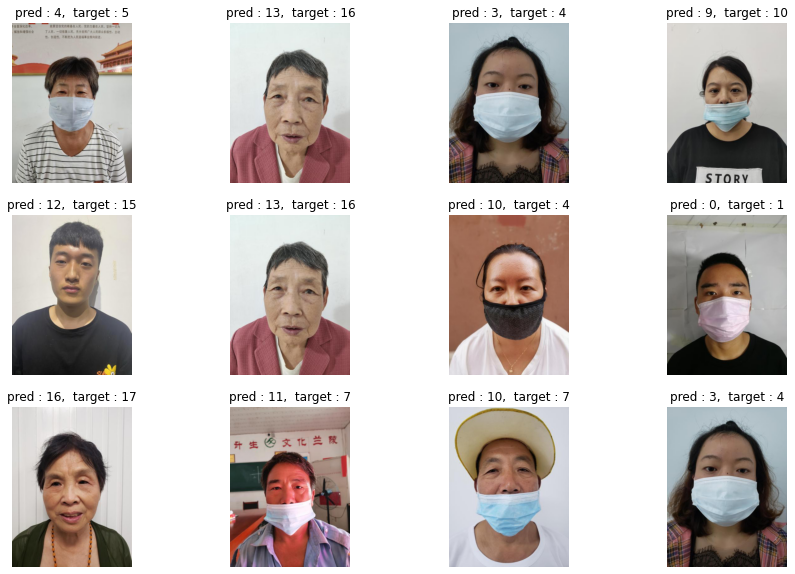

In [289]:
# 샘플 이미지 7개를 plt로 시각화
plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    num = random.randint(0,len(wrong_df))
    image_pil = Image.open(wrong_df['path'][num])
    image = np.array(image_pil)
    plt.imshow(image)
    plt.title(f'pred : {wrong_df["pred"][num]},  target : {wrong_df["target"][num]}')
    plt.axis('off')

## Submission

In [43]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)


        # albumentation
        # image = cv2.imread(self.img_paths[index])
        
        # # By default OpenCV uses BGR color space for color images,
        # # so we need to convert the image to RGB color space.
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # if self.transform:
        #     augmented = self.transform(image=image) 
        #     image = augmented['image']


        return image

    def __len__(self):
        return len(self.img_paths)

In [44]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

# # Transform Compose
# data_transform = transforms.Compose([
#     transforms.CenterCrop(320),
#     # transforms.Resize((512,384),Image.BILINEAR),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.2,0.2,0.2)),
# ])
dataset = TestDataset(image_paths, data_transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = model.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission12.csv'), index=False)
print('test inference is done!')

test inference is done!
